In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import pickle

In [132]:
df = pd.read_parquet('../data/all_data_preprocessed/all_merged.parquet')

In [133]:
X = df.drop(columns=[
        'event_all_region','alarms_in_regions',
    'event_6h_ago','event_3h_ago','event_12h_ago',
    'event_18h_ago','event_2h_ago', 'event_24h_ago'
])
y = df['event_all_region']

In [134]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [135]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [136]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
weight = sum(y_train==0)/sum(y_train==1)
weight

2.78725174626114

In [138]:
lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    # is_unbalance=True,  # Handles class imbalance
    # Alternative to is_unbalance:
    scale_pos_weight=weight,
    boosting_type='gbdt',
    learning_rate=0.07,
    num_leaves=31,
    min_child_samples=20,
    n_estimators=150,
    n_jobs=-1,
    random_state=42
)


In [139]:
lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 137007, number of negative: 381873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.625239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256871
[LightGBM] [Info] Number of data points in the train set: 518880, number of used features: 1040
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264044 -> initscore=-1.025056
[LightGBM] [Info] Start training from score -1.025056


LGBMClassifier(learning_rate=0.07, metric='auc', n_estimators=150, n_jobs=-1,
               objective='binary', random_state=42,
               scale_pos_weight=2.78725174626114)

In [140]:
y_pred = lgb_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.9161174067221708

In [141]:
confusion_matrix(y_test, y_pred)

array([[80508,  5246],
       [ 3459, 14563]])

In [142]:
f1_score(y_test, y_pred)

0.7698977029420316

In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     85754
         1.0       0.74      0.81      0.77     18022

    accuracy                           0.92    103776
   macro avg       0.85      0.87      0.86    103776
weighted avg       0.92      0.92      0.92    103776



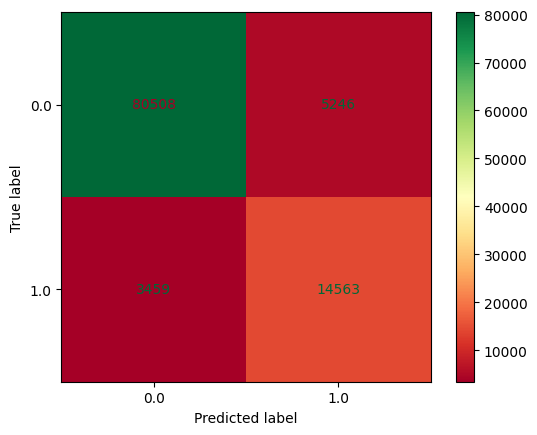

In [144]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='RdYlGn')

In [145]:
with open('our_models/3_LightGBM_1h.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)